# Singular Value Decomposition and Principal Component Analysis

Singular value decomposition (SVD) and principal component analysis (PCA) are both important tools for dimensionality reduction within machine learning. Dimensionality reduction is useful because it transforms the data into a lower-dimensional space where it hopefully retains some meaningful properties of the original data. Working in high-dimensional spaces can be undesirable for many reasons; raw data are often sparse as a consequence of the curse of dimensionality, and analyzing the data is usually computationally intractable.

Any real matrix \$(X \in \mathbb{R}^{n \times d}\)$ can be written as

$$X = U \Sigma V^T$$

where:
- \(U\) contains orthonormal left singular vectors,
- \($\Sigma\$) is a diagonal matrix of singular values,
- \(V\) contains orthonormal right singular vectors.

SVD decomposes a linear transformation into a rotation, a scaling, and another rotation. Columns of $V$ represent orthogonal directions in input space. Singular values indicate how much the data is stretched along each direction. By keeping only the largest singular values in $\Sigma\$ gives the best low-rank approximation to the data.

PCA seeks orthogonal directions that maximise variance in the data. It utilises SVD as $V$ is the column of principal components and $\Sigma\$ are the variances captured by these principals. This can then be used to find correlations within the data and reduce the dimensions.

Within this project, I implemented SVD and PCA from scratch to understand how it works, and then use it to construct eigenfaces from the scikit-learn dataset, fetch_lfw_people. Implementing the PCA meant reducing the dimensionality of the datatset (which is large as they are images and have thousands to millions of pixels) and reducing the time to train a model. With this trained model I was able to classify the person within the image with an accuracy score of 0.84.

### Assumptions

- The data matrix is numeric and finite-dimensional.
- Data has been mean-centred before applying PCA.
- Linear structure is sufficient to capture the dominant variation in the data.
- Variance is an appropriate proxy for information content.

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import LinearSVC

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=80, resize=1)

n_samples, height, width = lfw_people.images.shape

X = lfw_people.data
# Pixels
n_features = X.shape[1]

# Labels to predict ID of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print(f"number of samples: {n_samples}")
print(f"number of features: {n_features}")
print(f"number of classes: {n_classes}")

Total dataset size:
number of samples: 1140
number of features: 11750
number of classes: 5


In [3]:
def SVD(X, center=False, epsilon=1e-12):
    """
    Function to manually calculate entire SVD to ensure that I understand the inner workings of it.

    center=True if you want to center the data for PCA.
    """

    n, d = X.shape
    mu = X.mean(axis=0) if center else np.zeros(d, dtype=X.dtype)
    Xc = X - mu
    
    B = (Xc.T @ Xc)
    
    # Eigen-decomposition, note returns in ASCENDING order
    w, V = LA.eigh(B)
    
    # Put into hierarchical order
    idx = np.argsort(w)[::-1]
    w = w[idx]
    V = V[:, idx]
    
    Sigma = np.sqrt(np.clip(w, 0.0, None))
    
    # Left singular vectors: U = X V S^-1
    U = Xc @ V / np.maximum(Sigma, epsilon)
    
    
    return mu, U, Sigma, V.T

def Economy_SVD(U, Sigma, Vt, m):
    """
    Creates an economy SVD where it cuts off at the m'th column for an n x m matrix.
    """

    m = int(m)
    if m < 0 or m > len(Sigma):
        raise ValueError(f"m must be in [0, {len(Sigma)}]")
    U_m = U[:, :m]
    Sigma_m = Sigma[:m]
    Vt_m = Vt[:m, :]

    return U_m, Sigma_m, Vt_m

def Compression_Faces(mu, U, Sigma, Vt, idxs, m):
    """
    Reconstructs the original matrices for the faces using the cutoff at m instead of the entire matrix.
    idxs is the indexes for the faces to reconstruct.
    """

    U_m, Sigma_m, Vt_m = Economy_SVD(U, Sigma, Vt, m)

    idxs = np.atleast_1d(idxs).astype(int)

    # Scores for the selected samples
    scores = U_m[idxs] * Sigma_m

    Xhat = (scores @ Vt_m) + mu

    return Xhat

def PCA(X, mu, Vt, m, whiten=False, Sigma=None, epsilon=1e-12):
    """
    Project X into the first m principal components.
    If whiten=True, divide by singular values to equalise the variance.
    """

    Xc = X - mu
    Z = Xc @ Vt[:m].T
    if whiten:
        if Sigma is None:
            raise ValueError("Sigma required for whitening")
        Z = Z / (Sigma[:m] + epsilon)
        
    return Z

def Finetune(X_train, y_train, m_list, C_list, whiten=True, n_splits=5, seed=42):
    """
    Performs StratifiedKFold cross validation to find the best paramaters for the machine learning model.
    """

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    records = []
    for m in m_list:
        for C in C_list:
            scores = []
            for train_idx, val_idx in skf.split(X_train, y_train):
                X_tr, X_val = X_train[train_idx], X_train[val_idx]
                y_tr, y_val = y_train[train_idx], y_train[val_idx]
                
                mu, U, Sigma, Vt = SVD(X_tr, center=True)

                # Avoid dividing by 0
                r = int((Sigma > 1e-10).sum())
                m_eff = min(int(m), r)
                
                Z_train = PCA(X_tr, mu, Vt, m_eff, whiten=whiten, Sigma=Sigma)
                Z_val = PCA(X_val, mu, Vt, m_eff, whiten=whiten, Sigma=Sigma)
                
                clf = LinearSVC(C=C, class_weight="balanced", dual="auto", max_iter=20000)
                clf.fit(Z_train, y_tr)
                
                scores.append(accuracy_score(y_val, clf.predict(Z_val)))
            records.append((m, C, np.mean(scores), np.std(scores)))
    records.sort(key=lambda t: t[2], reverse=True)
    
    return records

def Plot_gallery(images, titles, height, width, n_row=3, n_col=4):
    """
    Helper function to plot portraits of people with their predicted classification and their true name.
    """

    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([])
        plt.yticks([])

def Title(y_pred, y_true, target_names, i):
    """
    Creates titles for the gallery showing predicted classification and true name.
    """
    
    pred_idx  = int(np.asarray(y_pred[i]))
    true_val  = y_true[i]

    if isinstance(true_val, (int, np.integer)) or np.issubdtype(np.asarray(true_val).dtype, np.integer):
        true_name = str(target_names[int(true_val)])
    else:
        true_name = str(true_val)

    pred_name = str(target_names[pred_idx])
    
    return f"Predicted: {pred_name.split()[-1]}\nTrue:       {true_name.split()[-1]}"

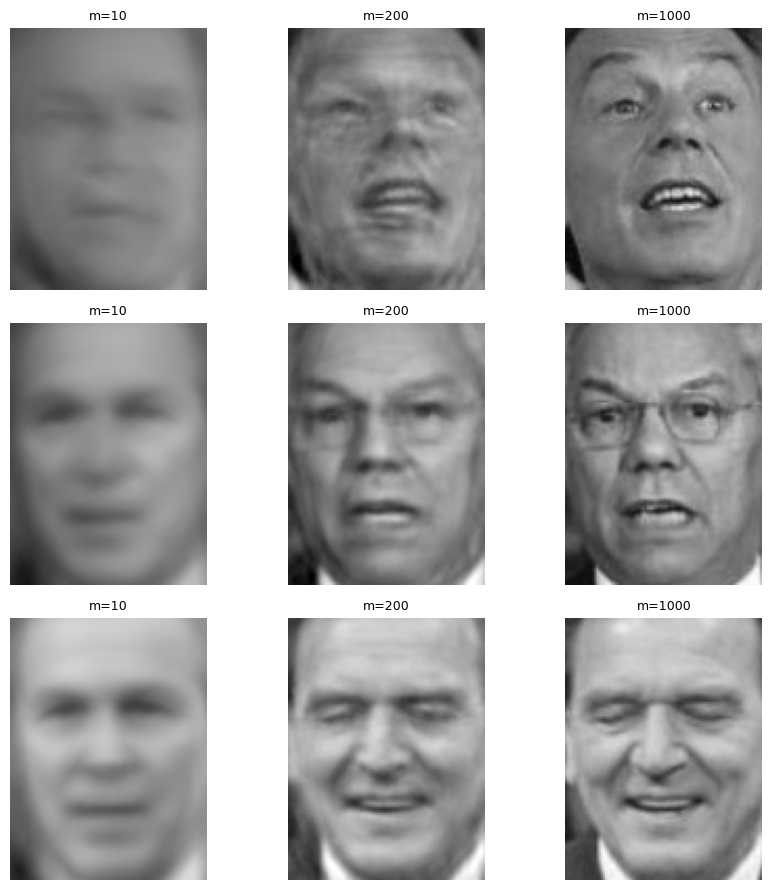

In [4]:
mu, U, Sigma, Vt = SVD(X, center=True)

ids = [3, 7, 10] # Face IDs
ms = [10, 200, 1000] # Different compression levels

factors = {m: Compression_Faces(mu, U, Sigma, Vt, ids, m) for m in ms}

# Get consistent contrast across all panels
vmin, vmax = X.min(), X.max()

fig, axes = plt.subplots(len(ids), len(ms), figsize=(3*len(ms), 3*len(ids)), squeeze=False)

for r, i in enumerate(ids):
    X_true = X[i]
    for c, m in enumerate(ms):
        Xhat = factors[m][r]

        ax = axes[r, c]
        ax.imshow(Xhat.reshape(height, width), cmap="gray", vmin=vmin, vmax=vmax)
        ax.set_title(f"m={m}", fontsize=9)
        ax.axis("off")

plt.tight_layout()
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

m_list = [100, 200, 300, 400, 500]
C_list = [0.3, 1.0, 2.0, 3.0, 5.0]

results = Finetune(X_train, y_train, m_list, C_list, whiten=True)

best_m, best_C, cv_mean, cv_std = results[0]
print(f"Chosen m={best_m}, C={best_C} (CV={cv_mean:.3f}±{cv_std:.3f})")

Chosen m=200, C=0.3 (CV=0.871±0.025)


Test accuracy: 0.842
                   precision    recall  f1-score   support

     Colin Powell      0.900     0.766     0.828        47
  Donald Rumsfeld      0.826     0.792     0.809        24
    George W Bush      0.866     0.915     0.890       106
Gerhard Schroeder      0.690     0.909     0.784        22
       Tony Blair      0.833     0.690     0.755        29

         accuracy                          0.842       228
        macro avg      0.823     0.814     0.813       228
     weighted avg      0.848     0.842     0.841       228



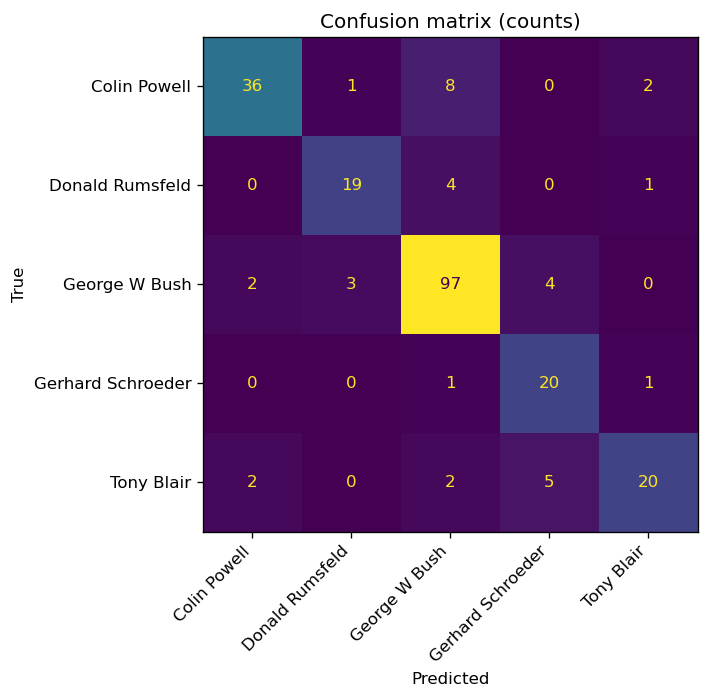

In [6]:
mu, U, Sigma, Vt = SVD(X_train, center=True)
Z_train = PCA(X_train, mu, Vt, best_m, whiten=True, Sigma=Sigma)
Z_test = PCA(X_test, mu, Vt, best_m, whiten=True, Sigma=Sigma)

clf = LinearSVC(C=best_C, class_weight="balanced", dual="auto", max_iter=20000)
clf.fit(Z_train, y_train)
y_pred = clf.predict(Z_test)

print(f"Test accuracy: {accuracy_score(y_test, y_pred):.3f}")

labels = getattr(clf, "classes_", np.unique(y_test))
# Map to names if you have them; otherwise use the labels themselves
if "target_names" in globals() and len(target_names) == len(labels):
    names = target_names
else:
    names = [str(l) for l in labels]

print(classification_report(y_test, y_pred, labels=labels, target_names=names, digits=3))

# Confusion matrix (counts)
cm = confusion_matrix(y_test, y_pred, labels=labels)
fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names).plot(ax=ax, colorbar=False)
ax.set_title("Confusion matrix (counts)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

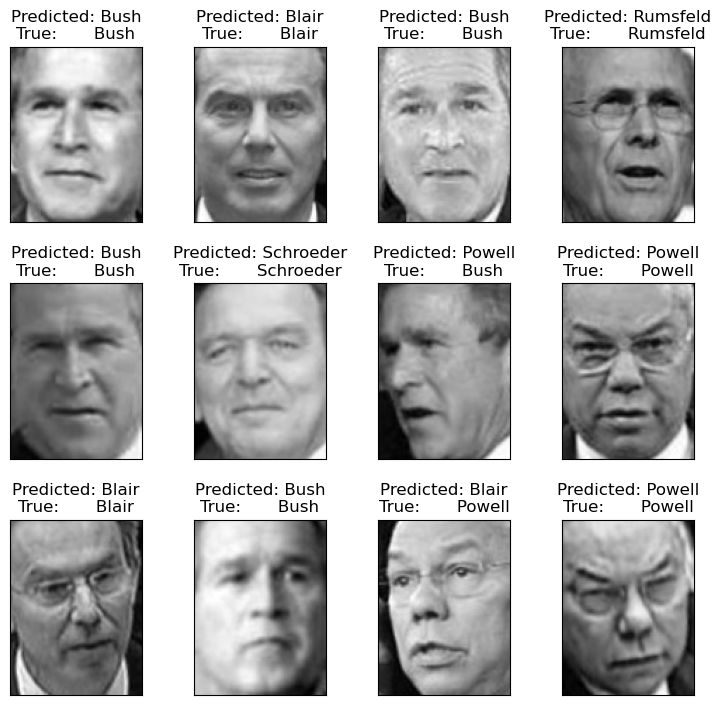

In [7]:
n = min(len(y_pred), len(y_test), X_test.shape[0], 12)

prediction_titles = [
    Title(y_pred, y_test, target_names, i) for i in range(n)
]

Plot_gallery(X_test[:n], prediction_titles[:n], height, width)

### Key takeaways

- SVD decomposes a matrix into orthogonal directions and associated scales.
- PCA is obtained directly from the SVD of a mean-centred data matrix.
- Principal components capture directions of maximal variance.
- PCA provides an optimal linear low-dimensional approximation in a least-squares sense.